## Titanic: Machine Learning from disaster

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [1]:
# packages
# data wrangling and analysis
import os
import csv
import itertools
import pandas as pd
import numpy as np
import random as rnd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# neural network
import keras
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense      # create layers
import tensorflow as tf
from tensorflow.contrib import learn as skflow

Using TensorFlow backend.


In [2]:
# option 1
# datasets - training and test set
# read train and test set, if the files don't exist, create them from original data
try:
    train_df = pd.read_csv("../data/original_train.csv")
    test_df =  pd.read_csv("../data/original_test.csv")
except FileNotFoundError:
    original = pd.read_excel("../data/titanic_original.xls", sheet="titanic3")
    original.drop(labels=['boat', 'body', 'home.dest'], axis=1, inplace=True)
    original_train, original_test = train_test_split(original, test_size=0.25, random_state=123)
    original_train.to_csv("../data/original_train.csv", sep=',', doublequote=True, index_label='passenger_id')
    original_test.to_csv("../data/original_test.csv", sep=',', doublequote=True, index_label='passenger_id')
    train_df = pd.read_csv("../data/original_train.csv")
    test_df =  pd.read_csv("../data/original_test.csv")

# combine train and test set
complete_df = pd.concat([train_df, test_df])

complete_df.columns = ['Passenger ID', 'Ticket Class','Survived', 'Full Name', 'Sex', 'Age', 'Siblings and Spouses',
       'Parents and Children', 'Ticket Number', 'Fare', 'Cabin Number', 'Embarked']
train_df.columns = ['Passenger ID', 'Ticket Class','Survived', 'Full Name', 'Sex', 'Age', 'Siblings and Spouses',
       'Parents and Children', 'Ticket Number', 'Fare', 'Cabin Number', 'Embarked']
test_df.columns = ['Passenger ID', 'Ticket Class','Survived', 'Full Name', 'Sex', 'Age', 'Siblings and Spouses',
       'Parents and Children', 'Ticket Number', 'Fare', 'Cabin Number', 'Embarked']

In [3]:
# # option 2
# # other dataset from kaggle
# train_df = pd.read_csv("../data/train.csv")
# test_df =  pd.read_csv("../data/test.csv")

# # which features are available in the dataset?
# # for kaggle datasets
# complete_df.columns = ['age', 'cabin', 'embarked', 'fare', 'name', 'parch', 'passenger_id', 'pclass',
#  'sex', 'sibsp', 'survived', 'ticket']
# train_df.columns = ['passenger_id', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
#        'parch', 'ticket', 'fare', 'cabin', 'embarked']
# test_df.columns = ['passenger_id', 'pclass', 'name', 'sex', 'age', 'sibsp',
#        'parch', 'ticket', 'fare', 'cabin', 'embarked']

# complete_df = pd.concat([train_df, test_df])

In [4]:
# lets look at some data to get a feeling for the data
train_df['Full Name'].head(10)


0                                        Bing, Mr. Lee
1                        Skoog, Miss. Margit Elizabeth
2                           Chapman, Mr. Charles Henry
3                     Caram, Mrs. Joseph (Maria Elias)
4                                    Smith, Mr. Thomas
5                                    Rugg, Miss. Emily
6                                   Smyth, Miss. Julia
7                                   Ivanoff, Mr. Kanio
8                   Goodwin, Master. William Frederick
9    Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...
Name: Full Name, dtype: object

In [5]:
# extra info about variables, missing values, number of rows, type of variables
train_df.info()
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
Passenger ID            981 non-null int64
Ticket Class            981 non-null int64
Survived                981 non-null int64
Full Name               981 non-null object
Sex                     981 non-null object
Age                     778 non-null float64
Siblings and Spouses    981 non-null int64
Parents and Children    981 non-null int64
Ticket Number           981 non-null object
Fare                    980 non-null float64
Cabin Number            212 non-null object
Embarked                979 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 92.0+ KB
Passenger ID              0
Ticket Class              0
Survived                  0
Full Name                 0
Sex                       0
Age                     203
Siblings and Spouses      0
Parents and Children      0
Ticket Number             0
Fare                      1
Cabin Number            769

## Exploratory Data analysis

In [6]:
# get some statistics
train_df.describe()

,Passenger ID,Ticket Class,Survived,Age,Siblings and Spouses,Parents and Children,Fare
count,981.000000,981.000000,981.000000,778.000000,981.000000,981.000000,980.000000
mean,663.195719,2.317023,0.377166,29.073907,0.495413,0.392457,32.405693
std,376.546984,0.828329,0.484924,14.038840,1.054257,0.900059,52.988024
min,0.000000,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,343.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.895800
50%,665.000000,3.000000,0.000000,27.000000,0.000000,0.000000,14.254150
75%,992.000000,3.000000,1.000000,36.500000,1.000000,0.000000,30.000000
max,1306.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
surv = train_df[train_df['Survived']==1]
nosurv = train_df[train_df['Survived']==0]
surv_col = "blue"
nosurv_col = "red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      %(len(surv), 1.*len(surv)/len(train_df)*100.0,\
        len(nosurv), 1.*len(nosurv)/len(train_df)*100.0, len(train_df)))

Survived: 370 (37.7 percent), Not Survived: 611 (62.3 percent), Total: 981


Median age survivors: 26.0, Median age non-survivers: 28.0


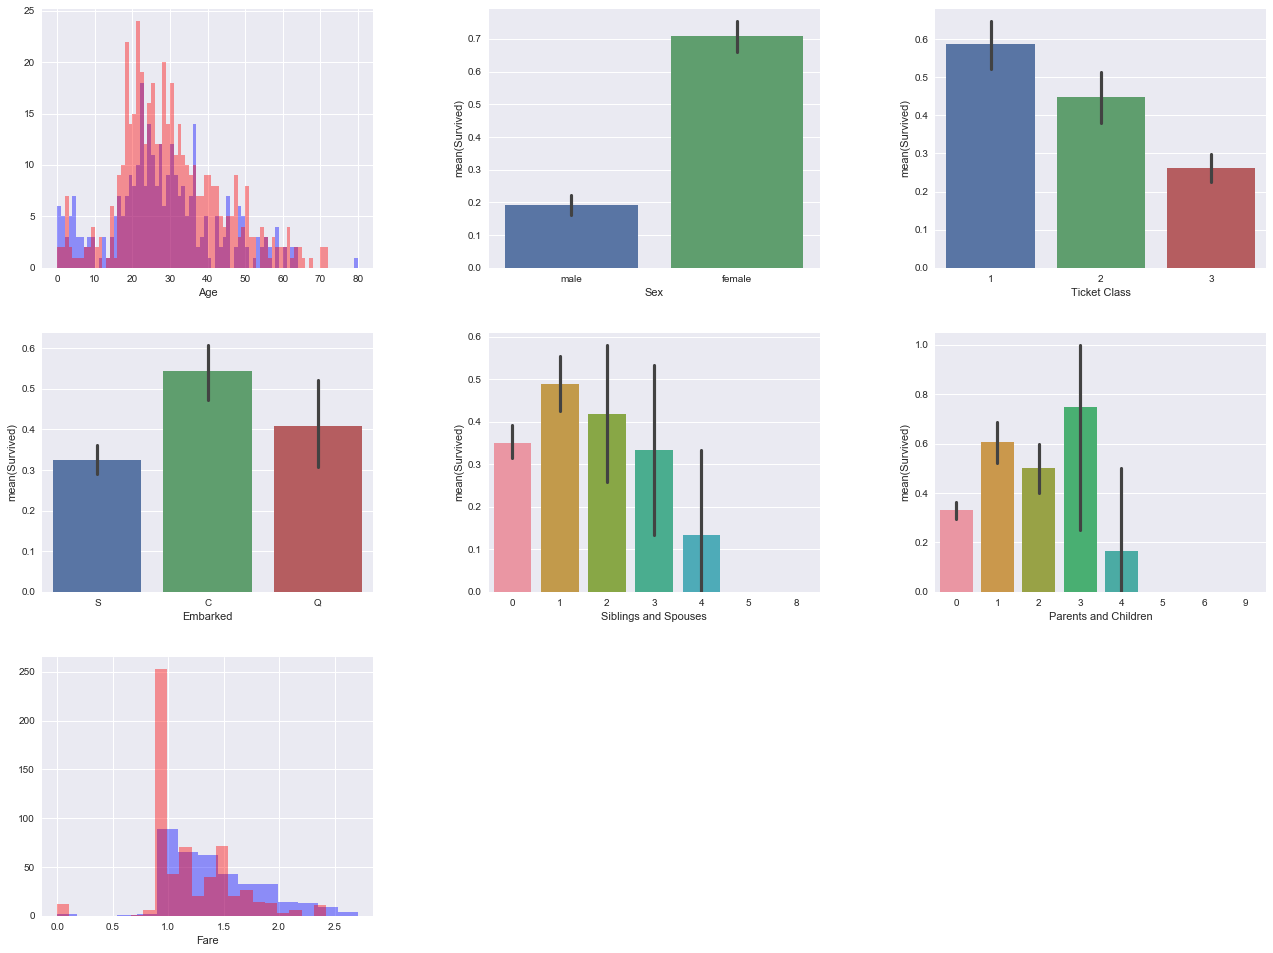

In [8]:
plt.figure(figsize=[20,15])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col, axlabel = 'Age')
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train_df)
plt.subplot(333)
sns.barplot('Ticket Class', 'Survived', data=train_df)
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train_df)
plt.subplot(335)
sns.barplot('Siblings and Spouses', 'Survived', data=train_df)
plt.subplot(336)
sns.barplot('Parents and Children', 'Survived', data=train_df)
plt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

print("Median age survivors: %.1f, Median age non-survivers: %.1f"\
      %(np.median(surv['Age'].dropna()), np.median(nosurv['Age'].dropna())))

<function matplotlib.pyplot.close>

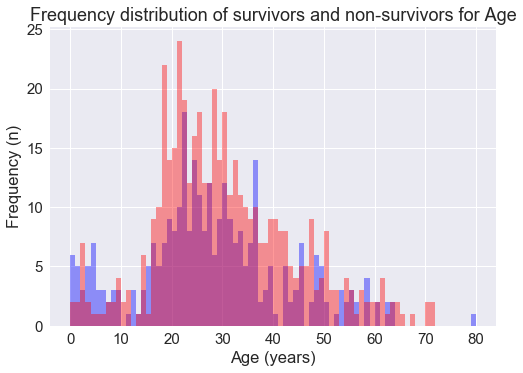

In [29]:
# Feature X survivor-nonsurvivor distribution plot
feature = 'Age'  # doesn't work for other features due to the bins and stuff

plt.figure()
ax = sns.distplot(surv[feature].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
ax = sns.distplot(nosurv[feature].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col, axlabel = feature)
plt.title('Frequency distribution of survivors and non-survivors for {}'.format(feature))
sns.set(font_scale = 1)
#sns.set_style("ticks", {"xtick.major.size":12, "ytick.major.size":12})

ax.set(xlabel='Age (years)', ylabel='Frequency (n)')
plt.savefig('../Titanic{}SurvivalDistribution.png'.format(feature), dpi=100, format='png', pad_inches=0.1, bbox_inches = 'tight')
plt.close

<function matplotlib.pyplot.close>

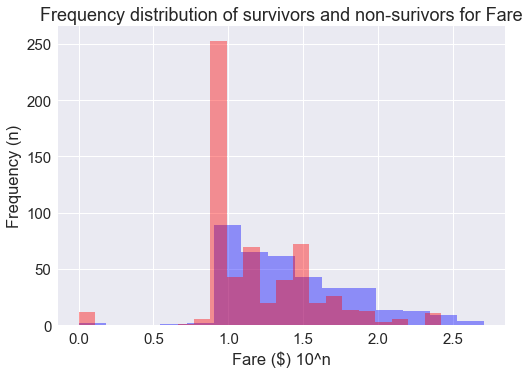

In [39]:
# Fare survivor-nonsurvivor distribution plot
feature= 'Fare'
plt.figure()
ax = sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
ax = sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
#sns.distplot(nosurv['Fare'].dropna().values+1, kde=False, color=nosurv_col,axlabel='Fare')
#sns.distplot(surv['Fare'].dropna().values+1, kde=False, color=surv_col)
ax.set(xlabel='Fare ($) 10^n', ylabel='Frequency (n)')
sns.set(font_scale = 1.5)


plt.title('Frequency distribution of survivors and non-surivors for {}'.format(feature))
plt.savefig('../Titanic{}SurvivalDistribution.png'.format(feature), dpi=100, format='png', pad_inches=0.1, bbox_inches = 'tight')
plt.close

<function matplotlib.pyplot.close>

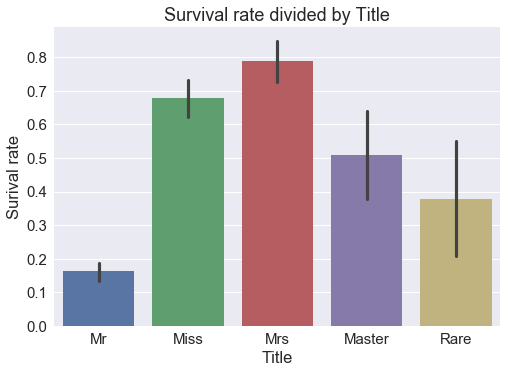

In [56]:
# Feature X plot
feature = 'Title'

plt.figure()
ax = sns.barplot(feature, 'Survived', data=complete_df)
plt.title('Survival rate divided by {}'.format(feature))
ax.set(xlabel= feature, ylabel='Surival rate')
sns.set(font_scale = 1.5)

plt.savefig('../Titanic{}Survivalrate.png'.format(feature), dpi=100, format='png', pad_inches=0.1, bbox_inches = 'tight')
plt.close

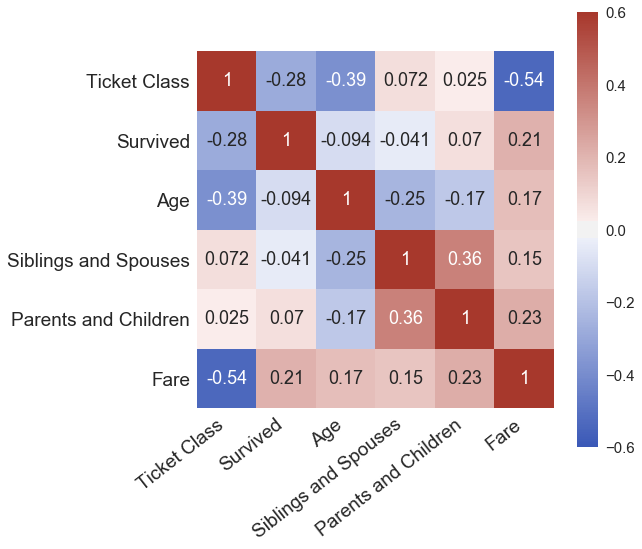

In [50]:
cmap = sns.diverging_palette(260, 15, s=75, l=40, n=9, as_cmap=True)
plt.figure(figsize=(8,8))
foo = sns.heatmap(train_df.drop('Passenger ID',axis=1).corr(), vmax=0.6, square=True, annot=True, cmap=cmap)
#foo.set_xticklabels(foo.get_xticklabels(), rotation=60)
#plt.xticks(rotation=45, ha='right')
plt.xticks(size = 19, rotation = 38, ha = 'right')
plt.yticks(size = 19)

#plt.suptitle('Titanic correlation matrix', fontsize=18)
foo.get_figure().savefig('../TitanicCorrelationMatrix.png', dpi=100, format='png', pad_inches=0.0, bbox_inches = 'tight')

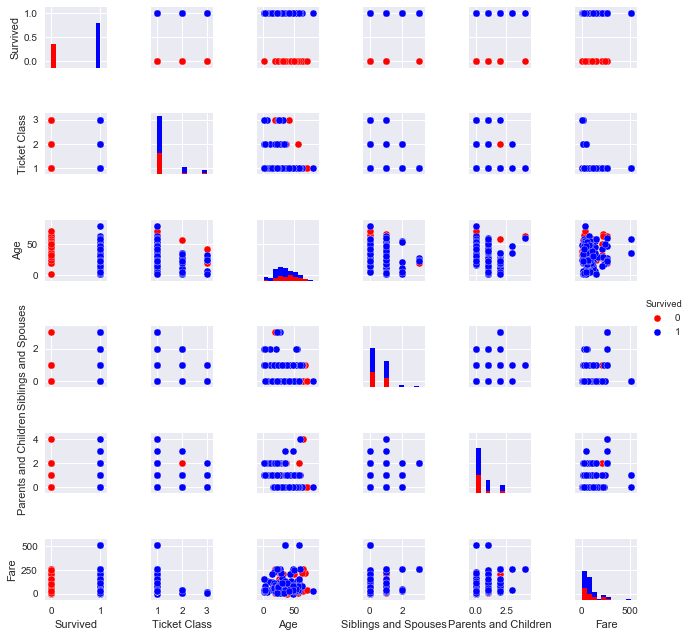

In [10]:
cols = ['Survived','Ticket Class','Age','Siblings and Spouses','Parents and Children','Fare']
g = sns.pairplot(data=train_df.dropna(), vars=cols, size=1.5,
                 hue='Survived', palette=[nosurv_col,surv_col])

Conlusions:
1. children younger than 10-ish had a better survival rate
2. being a 1st class passenger gives you better chances of survival
3. Having 1-3 siblings/spouses/parents/children on board (SibSp = 1-2, Parch = 1-3) suggests proportionally better survival numbers than being alone (SibSp + Parch = 0) or having a large family travelling with you.
4. Embarking at "C" resulted in a higher survival rate than embarking at "S"
5. Survival chances were much lower for the cheaper cabins / Fare


- Pclass is somewhat correlated with Fare (1st class tickets would be more expensive than 3rd class ones)
- SibSp and Parch are weakly correlated (large families would have high values for both; solo travellers would have zero for both)
- Pclass already correlates with Survived in a noticeable way

## Feature engineering

In [34]:
# Title
# extract title from name
complete_df['Title'] = complete_df['Full Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

complete_df['Title'] = complete_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
complete_df['Title'] = complete_df['Title'].replace('Mlle', 'Miss')
complete_df['Title'] = complete_df['Title'].replace('Ms', 'Miss')
complete_df['Title'] = complete_df['Title'].replace('Mme', 'Mrs')

# map titles to numeric values for model
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

complete_df['Title'] = complete_df['Title'].map(title_mapping)
complete_df['Title'] = complete_df['Title'].fillna(0)

complete_df['Title'] = complete_df['Title'].astype("category")

In [ ]:
cp,[;ete]

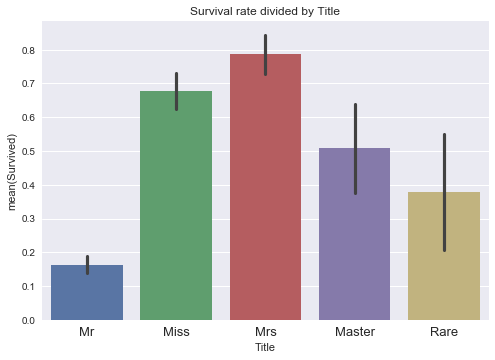

In [28]:
labels = ["Mr", "Miss", "Mrs", "Master", "Rare"]
feature = 'Title' 
foo = sns.barplot('Title', 'Survived', data=complete_df)
foo.set_xticklabels(labels, size = 13)
foo.set_title('Survival rate divided by Title')
foo.get_figure().savefig('../Titanic{}Survivalrate.png'.format(feature), dpi=100, format='png', pad_inches=0.4, bbox_inches = 'tight')

In [10]:
# Sex
# make dummies, no further engineering
complete_df['Sex'] = complete_df['Sex'].map( {'female': 1, 'male': 0} ).astype("category")

In [11]:
# Pclass
# make dummies, no further engineering
complete_df["Ticket Class"].replace("3rd", 3, inplace = True)
complete_df["Ticket Class"].replace("2nd", 2, inplace = True)
complete_df["Ticket Class"].replace("1st", 1, inplace = True)

complete_df["Ticket Class"] = complete_df["Ticket Class"].astype("category")

In [12]:
# Embarked
# two missing values in embarked, replace with most occuring
complete_df["Embarked"] = complete_df["Embarked"].fillna("S")

# dummies
complete_df["Embarked"].replace("S", 3, inplace = True)
complete_df["Embarked"].replace("C", 2, inplace = True)
complete_df["Embarked"].replace("Q", 1, inplace = True)

complete_df['Embarked'] = complete_df['Embarked'].astype("category")

In [13]:
# Fare
# fill missing Fare in with median
# fare could be imputed based on Pclass/Cabin
complete_df['Fare'].fillna(complete_df['Fare'].median(), inplace=True)

# # make fare categories
# pd.qcut(train_df['Fare'], 4)

# complete_df.loc[complete_df['Fare'] <= 7.90, 'Fare'] = 0
# complete_df.loc[(complete_df['Fare'] > 7.90) & (complete_df['Fare'] <= 14.254), 'Fare'] = 1
# complete_df.loc[(complete_df['Fare'] > 14.254) & (complete_df['Fare'] <= 30), 'Fare'] = 2
# complete_df.loc[complete_df['Fare'] > 30, 'Fare'] = 3
# complete_df['Fare'] = complete_df['Fare'].astype(int)

In [14]:
# Age
# 10% missing values, fill with mean
complete_df['Age'].fillna(complete_df['Age'].mean(), inplace=True)


### Extra

In [ ]:
# Child
complete_df['Young'] = complete_df['Age']<=10

# Young person
complete_df['Child'] = (complete_df['Age']<=30) | (complete_df['Title'].isin(['Master','Miss','Mlle']))

# Old person
complete_df['Old'] = complete_df['age']>=50

# Age group
complete_df['Age group'] = complete_df['Age']

complete_df.loc[complete_df['Age group'] <= 10, 'Age group'] = 0
complete_df.loc[(complete_df['Age group'] > 10) & (complete_df['Age group'] <= 18), 'Age group'] = 1
complete_df.loc[(complete_df['Age group'] > 18) & (complete_df['Age group'] <= 30), 'Age group'] = 2
complete_df.loc[(complete_df['Age group'] > 30) & (complete_df['Age group'] <= 50), 'Age group'] = 3
complete_df.loc[complete_df['Age group'] > 50, 'Age group'] = 4
complete_df['Age group'] = complete_df['Age group'].astype('int')

In [ ]:
# Cabin
# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
print("We know %i of %i Cabin numbers in the training data set and"
      %(len(train_df['Cabin Number'].dropna()), len(train_df)))
print("we know %i of %i Cabin numbers in the testing data set."
      %(len(test_df['Cabin Number'].dropna()), len(test_df)))

# Cabin known
complete_df['Cabin known'] = complete_df['Cabin Number'].isnull() == False

In [15]:
# Cabin
# determine deck
complete_df['Deck'] = complete_df['Cabin Number'].str[0]

# fill unknown cabins with "u"
complete_df['Deck'] = complete_df['Deck'].fillna(value='U').astype("category")

# make numerical representations
complete_df['Deck'] = complete_df['Deck'].map({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8, "U": 9}).astype("category")

In [18]:
# Ticket
print("There are %i unique ticket numbers among the %i tickets." \
      %(train_df['Ticket Number'].nunique(),train_df['Ticket Number'].count()))

# #type of ticket
# complete_df['ttype'] = complete_df['ticket'].str[0]

# # bad ticket
# complete_df['Bad Ticket'] = complete_df['ttype'].isin(['3','4','5','6','7','8','A','L','W'])

# # shared ticket
# complete_df['Shared Ticket'] = np.where(complete_df.groupby('Ticket Number')['Full Name'].transform('count') > 1, 1, 0)

# ticket group
complete_df['Ticket Group'] = complete_df.groupby('Ticket Number')['Full Name'].transform('count')
#complete_df['Ticket Group'] = complete_df.groupby('Ticket Number').ngroup()

There are 744 unique ticket numbers among the 981 tickets.


In [ ]:
# Family aboard
complete_df['Family'] =  complete_df['Parents and Children'] + complete_df['Siblings and Spouses']
complete_df['family']  = (complete_df['Siblings and Spouses'] + complete_df['Parents and Children']) > 0

# alone
complete_df['Alone']  = (complete_df['Siblings and Spouses'] + complete_df['Parents and Children']) == 0

# family size
complete_df['Large Family'] = (complete_df['Siblings and Spouses']>2) | (complete_df['Parents and Children']>3)

In [ ]:
# mother
complete_df['Mother'] = (complete_df['Age']>18) & (complete_df['Parents and Children']>0) & (complete_df['Title']!= 'Miss') & (complete_df['Sex'] == 1)

## Prepare for modelling

In [33]:
complete_df.head(10)

,Passenger ID,Ticket Class,Survived,Full Name,Sex,Age,Siblings and Spouses,Parents and Children,Ticket Number,Fare,Cabin Number,Embarked,Title,Deck,Ticket Group
0,674,3,1,"Bing, Mr. Lee",0,32.000000,0,0,1601,56.4958,NaN,3,Mr,9,8
1,1209,3,0,"Skoog, Miss. Margit Elizabeth",1,2.000000,3,2,347088,27.9000,NaN,3,Miss,9,6
2,367,2,0,"Chapman, Mr. Charles Henry",0,52.000000,0,0,248731,13.5000,NaN,3,Mr,9,1
3,706,3,0,"Caram, Mrs. Joseph (Maria Elias)",1,29.881135,1,0,2689,14.4583,NaN,2,Mrs,9,2
4,1215,3,0,"Smith, Mr. Thomas",0,29.881135,0,0,384461,7.7500,NaN,1,Mr,9,1
5,553,2,1,"Rugg, Miss. Emily",1,21.000000,0,0,C.A. 31026,10.5000,NaN,3,Miss,9,1
6,1216,3,1,"Smyth, Miss. Julia",1,29.881135,0,0,335432,7.7333,NaN,1,Miss,9,1
7,879,3,0,"Ivanoff, Mr. Kanio",0,29.881135,0,0,349201,7.8958,NaN,3,Mr,9,1
8,827,3,0,"Goodwin, Master. William Frederick",0,11.000000,5,2,CA 2144,46.9000,NaN,3,Master,9,8
9,749,3,0,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...",1,28.000000,1,1,347080,14.4000,NaN,3,Mrs,9,3


In [32]:
# save for dash web app
complete_df.to_csv('../data/export_titanic_dash.csv', index = False)

In [44]:
# split combined set again
train_df, test_df = train_test_split(complete_df, test_size=0.3, random_state=123)

# kaggle
#train_df = complete_df[:891]
#test_df = complete_df[891:]

# split train set in x and y
drop_cols = ['Survived', 'Full Name','Passenger ID','Ticket Number','Cabin Number','Deck','Ticket Group','Fare','Siblings and Spouses']
x_train = train_df.drop(drop_cols, axis=1)
y_train = train_df['Survived']

x_test = test_df.drop(drop_cols, axis=1)
y_test = test_df['Survived']

x_train.shape,x_test.shape, y_train.shape, y_test.shape

((916, 6), (393, 6), (916,), (393,))

## Modelling

In [45]:
# create logistic regression model
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
#acc_log = round(logreg.score(x_train, y_train) * 100, 2)
#acc_log

acc_log = accuracy_score(y_test, y_pred)
print(acc_log)
logreg.score(x_test, y_test)



0.7938931297709924


0.7938931297709924

In [46]:
coeff_df = pd.DataFrame(x_train.columns)
coeff_df.columns = ['Feature']
coeff_df['Coeficient'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Coeficient', ascending=False)

,Feature,Coeficient
1,Sex,2.093436
5,Title,0.446204
2,Age,-0.028840
4,Embarked,-0.149530
3,Parents and Children,-0.208783
0,Ticket Class,-0.984256


In [31]:
# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('True negative {}'.format(tn))
print('False positive {}'.format(fp))
print('False negative {}'.format(fn))
print('True positive {}'.format(tp))
confusion_matrix(y_test, y_pred)

True negative 213
False positive 35
False negative 51
True positive 94


array([[213,  35],
       [ 51,  94]])

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.86      0.83       248
          1       0.73      0.65      0.69       145

avg / total       0.78      0.78      0.78       393



In [ ]:
# roc curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
# Support vector machine
svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
#acc_svc = round(svc.score(x_train, y_train) * 100, 2)
#acc_svc

acc_svc = accuracy_score(y_test, y_pred)
acc_svc

In [ ]:
# K neirest neighbor
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
#acc_knn = round(knn.score(x_train, y_train) * 100, 2)
#acc_knn

acc_knn = accuracy_score(y_test, y_pred)
acc_knn

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_test)
#acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
#acc_gaussian

acc_gaussian = accuracy_score(y_test, y_pred)
acc_gaussian

In [ ]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_test)
#acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
#acc_linear_svc

acc_linear_svc = accuracy_score(y_test, y_pred)
acc_linear_svc

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
#acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
#acc_decision_tree

acc_decision_tree = accuracy_score(y_test, y_pred)
acc_decision_tree

In [47]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
random_forest.score(x_train, y_train)
#acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
#acc_random_forest

acc_random_forest = accuracy_score(y_test, y_pred)
acc_random_forest

0.7506361323155216

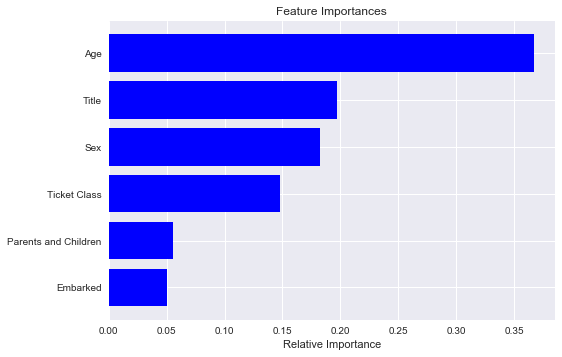

In [51]:
# feature importance
features = x_train.columns
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
#plt.show()
plt.savefig('../Titanic{}SurvivalDistribution.png'.format(feature), dpi=200, format='png', pad_inches=0.1, bbox_inches = 'tight')
#plt.close

In [ ]:
# Neural network

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = 18))
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(x_train, y_train, batch_size = 32, epochs = 500)

In [ ]:
# accuracy
y_pred = model.predict(x_test)
acc_NN = accuracy_score(y_test, y_pred>0.5)
acc_NN

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Model evaluation

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree', "Neural network"],
    'Score': [acc_svc*100, acc_knn*100, acc_log*100, 
              acc_random_forest*100, acc_gaussian*100, acc_linear_svc*100, acc_decision_tree*100, acc_NN*100]})
models.sort_values(by='Score', ascending=False)

In [ ]:
# roc curve

def plot_roc_curve(x_test, y_test, model):
    model_type = str(model).split('(')[0]
    model_roc_auc = roc_auc_score(y_test, model.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (model_type, model_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
#     plt.savefig('Log_ROC')
    plt.show()

# put in different models for their respective ROC-curve, doesn't work on all models
plot_roc_curve(x_test, y_test, logreg)

In [ ]:
# accuracy score

def print_accuracy(x_test, y_test, model):
    acc_score = cross_val_score(model, x_test, y_test, scoring='accuracy')
    print("Accuracy: %.3f (%.3f)" % (acc_score.mean(), acc_score.std()))

print_accuracy(x_test, y_test, logreg)

In [ ]:
# logarithmic loss  https://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

def print_logloss(x_test, y_test, model):
    acc_score = cross_val_score(model, x_test, y_test, scoring='neg_log_loss')
    print("Logloss: %.3f (%.3f)" % (acc_score.mean(), acc_score.std()))

print_logloss(x_test, y_test, logreg)

[[212  36]
 [ 45 100]]


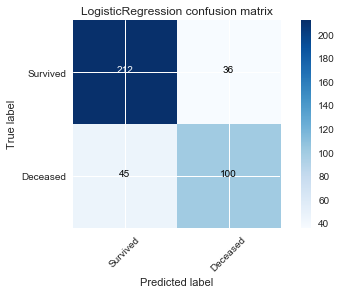

In [34]:
# confusion matrix

def print_confusion_matrix(x_test, y_test, model):
    y_pred = model.predict(x_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    print(con_matrix)
    
def plot_confusion_matrix(x_test, y_test, model):
    model_type = str(model).split('(')[0]
    outcome = ['Survived', 'Deceased']
    y_pred = model.predict(x_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    
    plt.figure()
    plt.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('%s confusion matrix' % model_type)
    plt.colorbar()
    tick_marks = np.arange(len(outcome))
    plt.xticks(tick_marks, outcome, rotation=45)
    plt.yticks(tick_marks, outcome)
    
    fmt = 'd'
    thresh = con_matrix.max() / 2.
    for i, j in itertools.product(range(con_matrix.shape[0]), range(con_matrix.shape[1])):
        plt.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print_confusion_matrix(x_test, y_test, logreg)
plot_confusion_matrix(x_test, y_test, logreg)

In [ ]:
# classification report

def print_classification_report(x_test, y_test, model):
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred)
    print(report)

print_classification_report(x_test, y_test, logreg)

## Export for Kaggle

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["passenger_id"],
        "Survived": y_pred.astype("int")
    })
submission.to_csv('titanic.csv', index=False)